In [2]:
import torch
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
from matplotlib import rc
matplotlib.rcParams['figure.dpi'] = 150
f_path = "/System/Library/Fonts/Helvetica.ttc"
font_name = fm.FontProperties(fname=f_path).get_name()
rc('font', family=font_name, size=13)

import matplotlib.pyplot as plt
from sentence_transformers import models, SentenceTransformer
from collections import defaultdict
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from scipy.stats import binned_statistic

## Load necessary info

In [3]:
with open('../dataset/User_survey/issue2groups(useridx).p', 'rb') as f:
    category2groups = pickle.load(f)
    
with open('../dataset/User_survey/idx2user.p', 'rb') as f:
    idx2user = pickle.load(f)    
    
with open('../dataset/UserEmbeddings/user2embeddingvector_data(0)_model(model_roberta-base_ft).p', 'rb') as f:
    user2embedding_ft = pickle.load(f)        

In [4]:
usermat_ft = []
usernames = []

for user in user2embedding_ft:
    usermat_ft.append(user2embedding_ft[user])
    usernames.append(user)
    
usermat_ft = np.array(usermat_ft)

## Calculating issue vectors

In [9]:
from scipy.spatial import distance

In [13]:
issue2vector = {}
issue2cos_dist = {}
issue2euc_dist = {}

for issue in list(category2groups.keys()): 
    
    if issue=='Religion' or issue=='Political party':
        continue 
        
    print(issue)

    g1, g2 = category2groups[issue].keys()

    g1_indices = category2groups[issue][g1]
    g2_indices = category2groups[issue][g2]
    print(g1, usermat_ft[g1_indices].shape)
    print(g2, usermat_ft[g2_indices].shape)

    group2avgvector = {}
    group2avgvector[g1] = usermat_ft[g1_indices].mean(axis=0)
    group2avgvector[g2] = usermat_ft[g2_indices].mean(axis=0)

    issue2vector[issue] = group2avgvector[g1] - group2avgvector[g2]
    
    
    issue2euc_dist[issue] = np.linalg.norm(issue2vector[issue])
    issue2cos_dist[issue] = distance.cosine(group2avgvector[g1], group2avgvector[g2])


Abortion
Pro (5138, 768)
Con (5046, 768)
Affirmative Action
Pro (1970, 768)
Con (3648, 768)
Animal Rights
Pro (4807, 768)
Con (1033, 768)
Barack Obama
Pro (2225, 768)
Con (2962, 768)
Border Fence
Pro (3713, 768)
Con (3459, 768)
Capitalism
Pro (3562, 768)
Con (1331, 768)
Civil Unions
Pro (4255, 768)
Con (1640, 768)
Death Penalty
Pro (4889, 768)
Con (4749, 768)
Drug Legalization
Pro (4683, 768)
Con (4388, 768)
Electoral College
Pro (1555, 768)
Con (2399, 768)
Environmental Protection
Pro (7037, 768)
Con (1007, 768)
Estate Tax
Pro (1782, 768)
Con (3042, 768)
European Union
Pro (1792, 768)
Con (1189, 768)
Euthanasia
Pro (3776, 768)
Con (1748, 768)
Federal Reserve
Pro (1117, 768)
Con (1289, 768)
Flat Tax
Pro (2093, 768)
Con (2637, 768)
Free Trade
Pro (3030, 768)
Con (682, 768)
Gay Marriage
Pro (6509, 768)
Con (2725, 768)
Global Warming Exists
Pro (6043, 768)
Con (2120, 768)
Globalization
Pro (2180, 768)
Con (1015, 768)
Gold Standard
Pro (1321, 768)
Con (1134, 768)
Gun Rights
Pro (5840, 768)

### euc_dist vs cos_dist

In [22]:
from scipy.stats import pearsonr

(0.9907155962166038, 1.6130072189171758e-41)


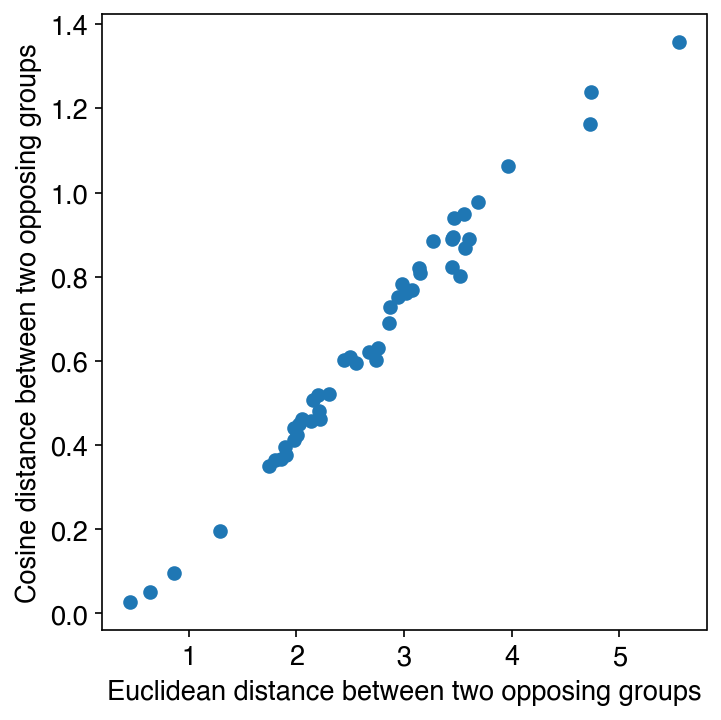

In [24]:
d_euc = []
d_cos = []

for issue in issue2euc_dist:
    d_euc.append(issue2euc_dist[issue])   
    d_cos.append(issue2cos_dist[issue])
    
fig = plt.figure(figsize=(5,5))
plt.plot(d_euc, d_cos,'o')    
plt.xlabel('Euclidean distance between two opposing groups')
plt.ylabel('Cosine distance between two opposing groups')

plt.tight_layout()
plt.savefig('../fig/Issue_vector/Euclidean_vs_Cosine.pdf',transparent=True)
print(pearsonr(d_euc, d_cos))

In [5]:
issue_mat = []
for issue in issue2vector:
    issue_mat.append(issue2vector[issue])
    
issue_mat = np.array(issue_mat)    
issue_mat.shape

(48, 768)

In [6]:
issue_vec_norms = np.linalg.norm(issue_mat, axis=1)
issue_titles = [issue for issue in issue2vector]

df_iv = pd.DataFrame({'Issue':issue_titles, 'Norm':issue_vec_norms})    
df_iv = df_iv.sort_values(by='Norm', ascending=0)

In [7]:
df_iv.to_pickle('../dataset/User_survey/df_issuevector.pkl')

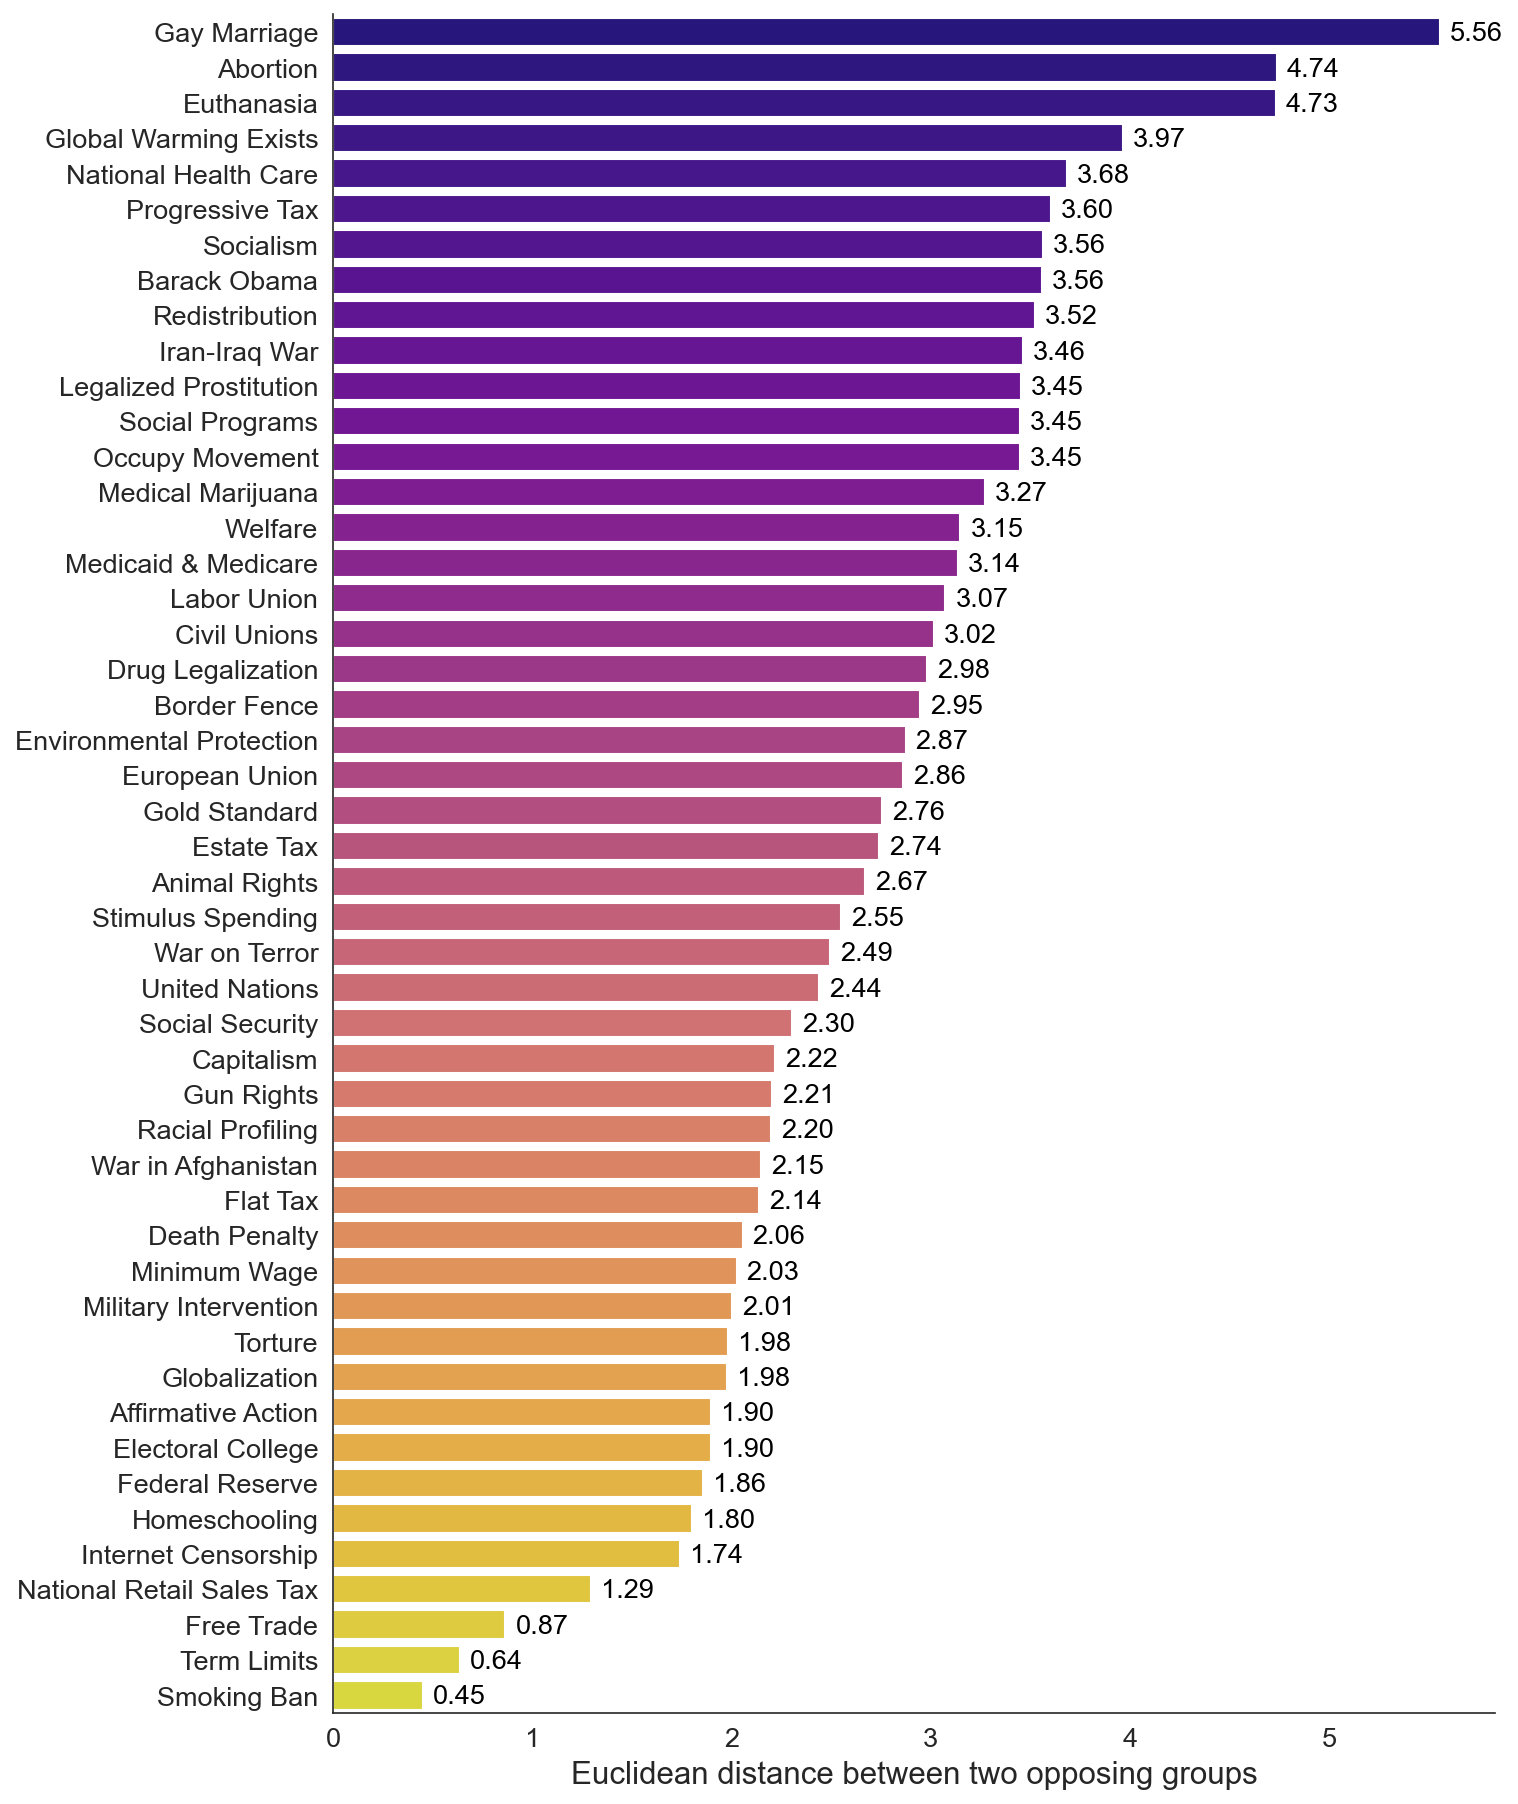

In [8]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 15))

sns.barplot(x="Norm", y="Issue", data=df_iv, palette='plasma')

for idx, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(p.get_width()+0.05, p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),ha='left', va='center', size=13, color='k')

plt.ylabel('Social Issue', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Euclidean distance between two opposing groups', fontsize=15)
ax.set_ylabel("")

plt.savefig('../fig/Issue_vector/48issue_vector_distance.pdf', transparent=True, bbox_inches='tight')

## Comparison with survey result 

In [9]:
import json
with open('../dataset/01_rawdata/users.json','r') as f:
    userinfo = json.load(f)

In [10]:
stance_mat = np.empty((len(usernames), 48+1))#big issues + political party
stance_mat[:] = np.nan 

for user_idx, e in enumerate(usernames): 
    if not e in userinfo: continue
    
    for idx, issue in enumerate(userinfo[e]['big_issues_dict']):
        if userinfo[e]['big_issues_dict'][issue] == 'Pro':
            stance_mat[user_idx, idx] = 1 
        elif userinfo[e]['big_issues_dict'][issue] == 'Con':
            stance_mat[user_idx, idx] = 0 

    if userinfo[e]['party'] == 'Republican Party':
        stance_mat[user_idx, 48] = 1
    elif userinfo[e]['party']== 'Democratic Party':
        stance_mat[user_idx, 48] = 0
    
    """if 'Christian' in userinfo[e]['religious_ideology']:
        stance_mat[user_idx, 49] = 1
    elif userinfo[e]['religious_ideology'] == 'Atheist':
        stance_mat[user_idx, 49] = 0"""

In [11]:
stance_mat.shape

(35447, 49)

In [12]:
column = list(userinfo[e]['big_issues_dict'].keys()) + ['Political_party'] # ['Religion'] 
df_stance = pd.DataFrame(stance_mat, columns=column)
df_stance = df_stance.dropna(subset=['Political_party'])

print(df_stance.shape)
df_stance.head()

(3335, 49)


,Abortion,Affirmative Action,Animal Rights,Barack Obama,Border Fence,Capitalism,Civil Unions,Death Penalty,Drug Legalization,Electoral College,...,Social Security,Socialism,Stimulus Spending,Term Limits,Torture,United Nations,War in Afghanistan,War on Terror,Welfare,Political_party
8,0.0,NaN,1.0,1.0,1.0,NaN,1.0,0.0,0.0,1.0,...,1.0,NaN,NaN,NaN,0.0,1.0,NaN,1.0,1.0,0.0
32,0.0,NaN,NaN,0.0,NaN,1.0,NaN,1.0,0.0,0.0,...,NaN,0.0,NaN,NaN,0.0,NaN,1.0,1.0,NaN,1.0
57,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,0.0


In [13]:
df_rep = df_stance[df_stance['Political_party']==1]
df_dem = df_stance[df_stance['Political_party']==0]

In [14]:
rep_count = []
dem_count = []

for col in column:
    rep_count.append(len(df_rep[col].dropna()))
    dem_count.append(len(df_dem[col].dropna()))

print('The number of samples for each issue')    
print('rep:', rep_count)
print('dem:', dem_count)


The number of samples for each issue
rep: [1335, 857, 591, 791, 1153, 718, 802, 1301, 1220, 603, 970, 745, 354, 659, 343, 755, 529, 1136, 1054, 376, 320, 1250, 559, 618, 846, 751, 605, 832, 1075, 472, 972, 969, 682, 366, 674, 899, 411, 1048, 736, 877, 620, 342, 943, 611, 932, 949, 1090, 948, 1683]
dem: [1207, 734, 628, 648, 959, 455, 863, 1163, 1069, 482, 1133, 673, 340, 639, 255, 666, 362, 1177, 1116, 330, 265, 985, 412, 534, 952, 790, 450, 970, 1051, 360, 1005, 987, 580, 255, 619, 903, 222, 940, 841, 924, 356, 245, 837, 562, 994, 984, 944, 927, 1652]


In [15]:
#이슈별 찬성 비율
pro_ratio = pd.DataFrame(df_rep.mean(axis=0), columns=['Republican'])
pro_ratio['Democratic'] = df_dem.mean(axis=0)

pro_ratio['N_Rep'] = rep_count
pro_ratio['N_Dem'] = dem_count

pro_ratio = pro_ratio.drop(index='Political_party')

pro_ratio['Difference'] = pro_ratio['Republican'] - pro_ratio['Democratic']
pro_ratio['Absolute_difference'] = np.abs(pro_ratio['Republican'] - pro_ratio['Democratic'])

pro_ratio.index.name = 'Social_issue'

In [16]:
#combine with issue vector distance data
df_iv.columns = ['Social_issue', 'Euclidean_distance']

issue2eucdist = {}
for i in range(len(df_iv)):
    issue2eucdist[df_iv.iloc[i]['Social_issue']] = df_iv.iloc[i]['Euclidean_distance']
    
pro_ratio['Euclidean_distance'] = pro_ratio.index.map(issue2eucdist)    

pro_ratio.to_csv('../dataset/User_survey/ddo_issue_survey_pro_ratio.csv', sep=',')

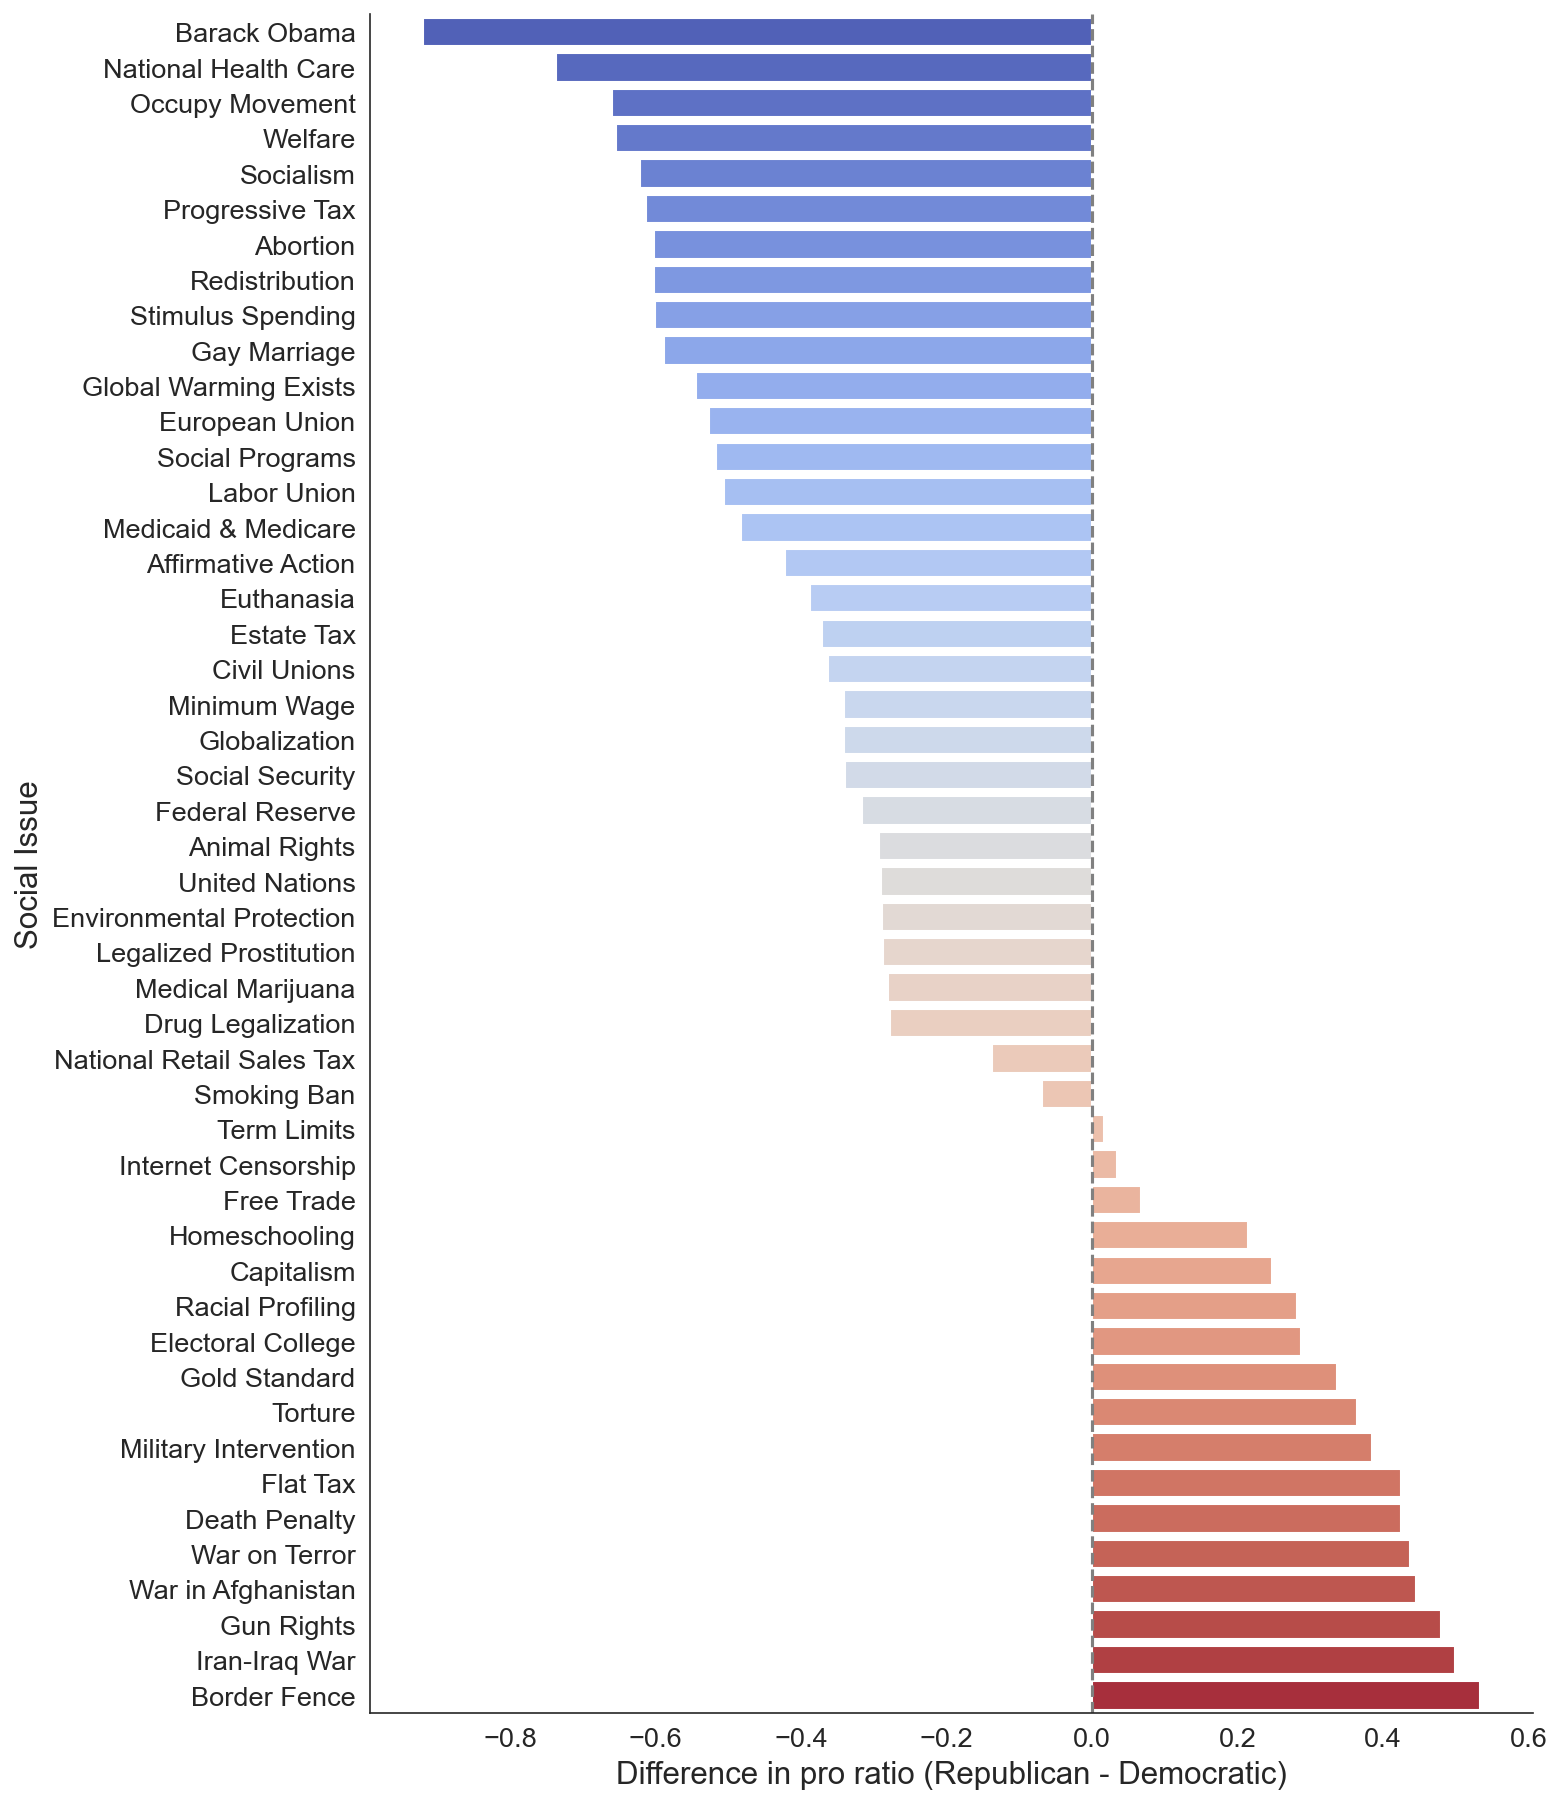

In [17]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(10, 15))
sorted_data = pro_ratio.sort_values(by='Difference')
sns.barplot(x='Difference', y=sorted_data.index, data=sorted_data, palette='coolwarm')
#plt.title('Difference in pro ratios between Republican and Democratic parties', fontsize=15)
plt.xlabel('Difference in pro ratio (Republican - Democratic)', fontsize=15)
plt.ylabel('Social Issue', fontsize=15)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=13)
plt.axvline(x=0, color='grey', linestyle='--')  # Mark the 0 difference
plt.savefig('../fig/Issue_vector/ddo_issue_pro_ratio_difference.pdf', transparent=True, bbox_inches='tight')
plt.show()

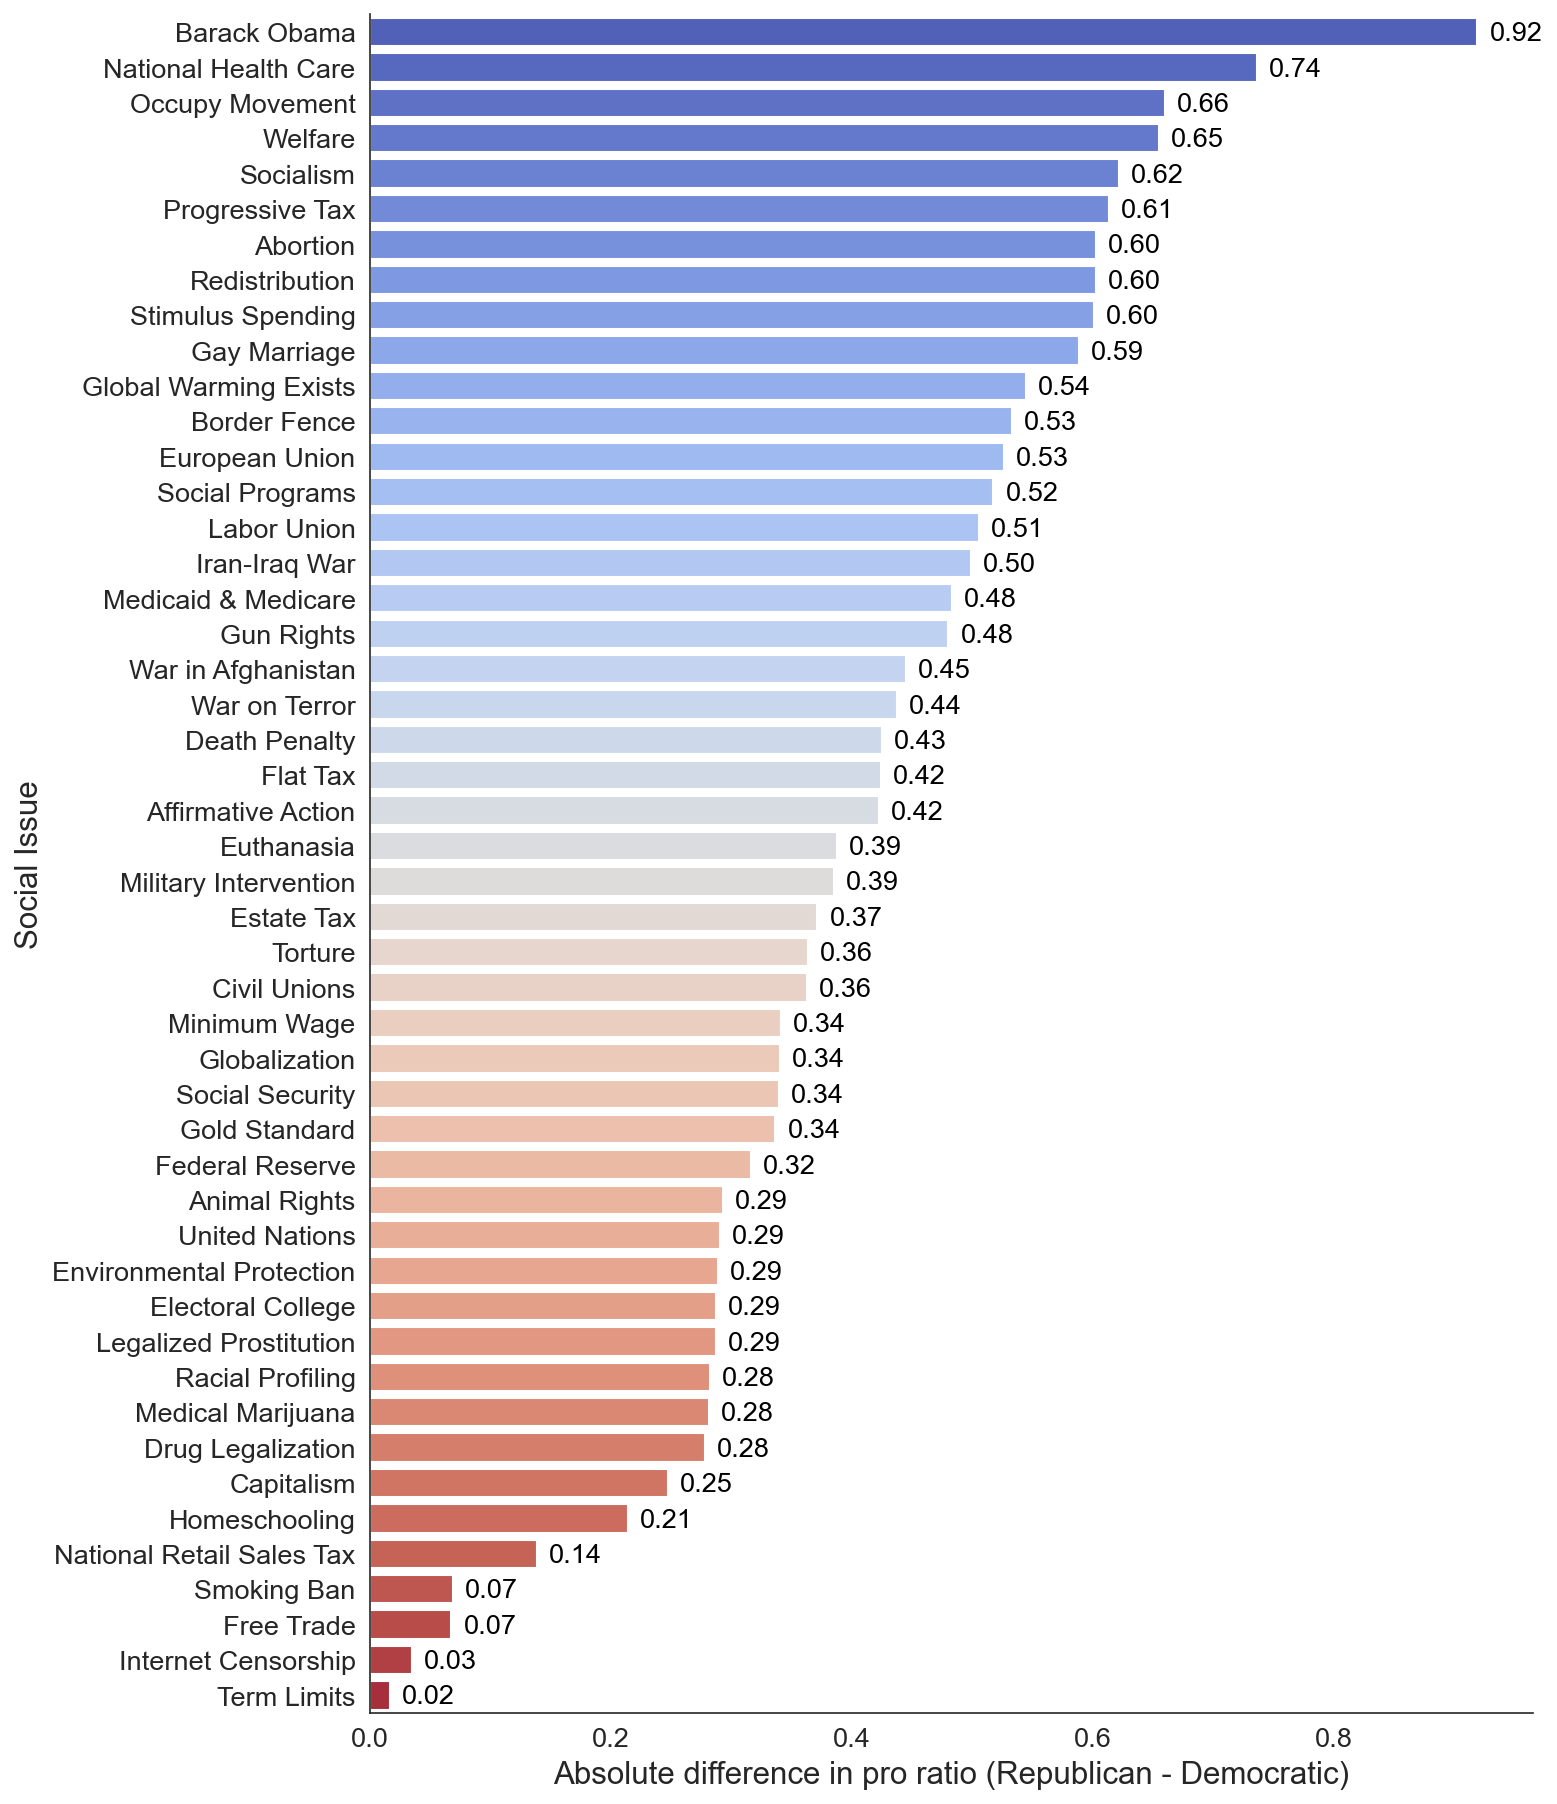

In [18]:
fig, ax = plt.subplots(figsize=(10, 15))
sorted_data = pro_ratio.sort_values(by='Absolute_difference', ascending=False)
sns.barplot(x='Absolute_difference', y=sorted_data.index, data=sorted_data, palette='coolwarm')
#plt.title('Absolute difference in Pro ratios between republican and democratic parties', fontsize=15)

for idx, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(p.get_width()+0.01, p.get_y()+0.55*p.get_height(),
             '{:1.2f}'.format(width),ha='left', va='center', size=13, color='k')

plt.xlabel('Absolute difference in pro ratio (Republican - Democratic)', fontsize=15)
plt.ylabel('Social Issue', fontsize=15)
plt.yticks(fontsize=13)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=13)
plt.savefig('../fig/Issue_vector/ddo_issue_pro_ratio_abs_difference.pdf', transparent=True, bbox_inches='tight')
plt.show()

### correlation with issue vector distance  

In [19]:
from scipy.stats import pearsonr

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


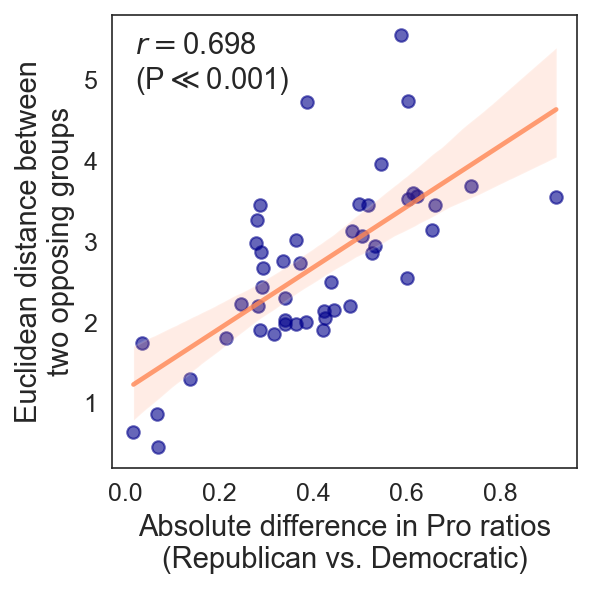

In [21]:
pcc = pearsonr(pro_ratio['Absolute_difference'], pro_ratio['Euclidean_distance'])[0]
pvalue = pearsonr(pro_ratio['Absolute_difference'], pro_ratio['Euclidean_distance'])[1]

plt.figure(figsize=(4,4))
sns.regplot(x='Absolute_difference', y='Euclidean_distance', data=pro_ratio, scatter_kws={'color':'darkblue','alpha':0.6}, line_kws={'color':'#FF8653', 'alpha':0.8})
plt.xlabel('Absolute difference in Pro ratios\n(Republican vs. Democratic)', fontsize=14)
plt.ylabel('Euclidean distance between\ntwo opposing groups', fontsize=14)
plt.text(x=0.02, y=4.9, s=r'$r=$%.3f'%(pcc) + '\n(P$\ll$0.001)', fontsize=14)
plt.legend(frameon=False, loc=2, fontsize=13)
plt.savefig('../fig/Issue_vector/ddo_issue_pro_ratio_correlation_scatter.pdf', transparent=True, bbox_inches='tight')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [115]:
pvalue

3.521319400364047e-08

In [131]:
pro_ratio.sort_values(by='Absolute_difference', ascending=False)

,Republican,Democratic,N_Rep,N_Dem,Difference,Absolute_difference,Euclidean_distance
Social_issue,,,,,,,
Barack Obama,0.041719,0.961420,791,648,-0.919700,0.919700,3.557094
National Health Care,0.211558,0.948328,969,987,-0.736770,0.736770,3.683151
Occupy Movement,0.084699,0.745098,366,255,-0.660399,0.660399,3.446530
Welfare,0.245781,0.900755,948,927,-0.654975,0.654975,3.148876
Socialism,0.046774,0.668539,620,356,-0.621765,0.621765,3.563464
Progressive Tax,0.195846,0.809370,674,619,-0.613524,0.613524,3.604475
Abortion,0.151311,0.753935,1335,1207,-0.602625,0.602625,4.737672
Redistribution,0.104623,0.707207,411,222,-0.602584,0.602584,3.521220
Stimulus Spending,0.198830,0.800000,342,245,-0.601170,0.601170,2.551922


## Correlation between issue vectors

In [95]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_mat = cosine_similarity(issue_mat)
issue_labels = list(issue2vector.keys())

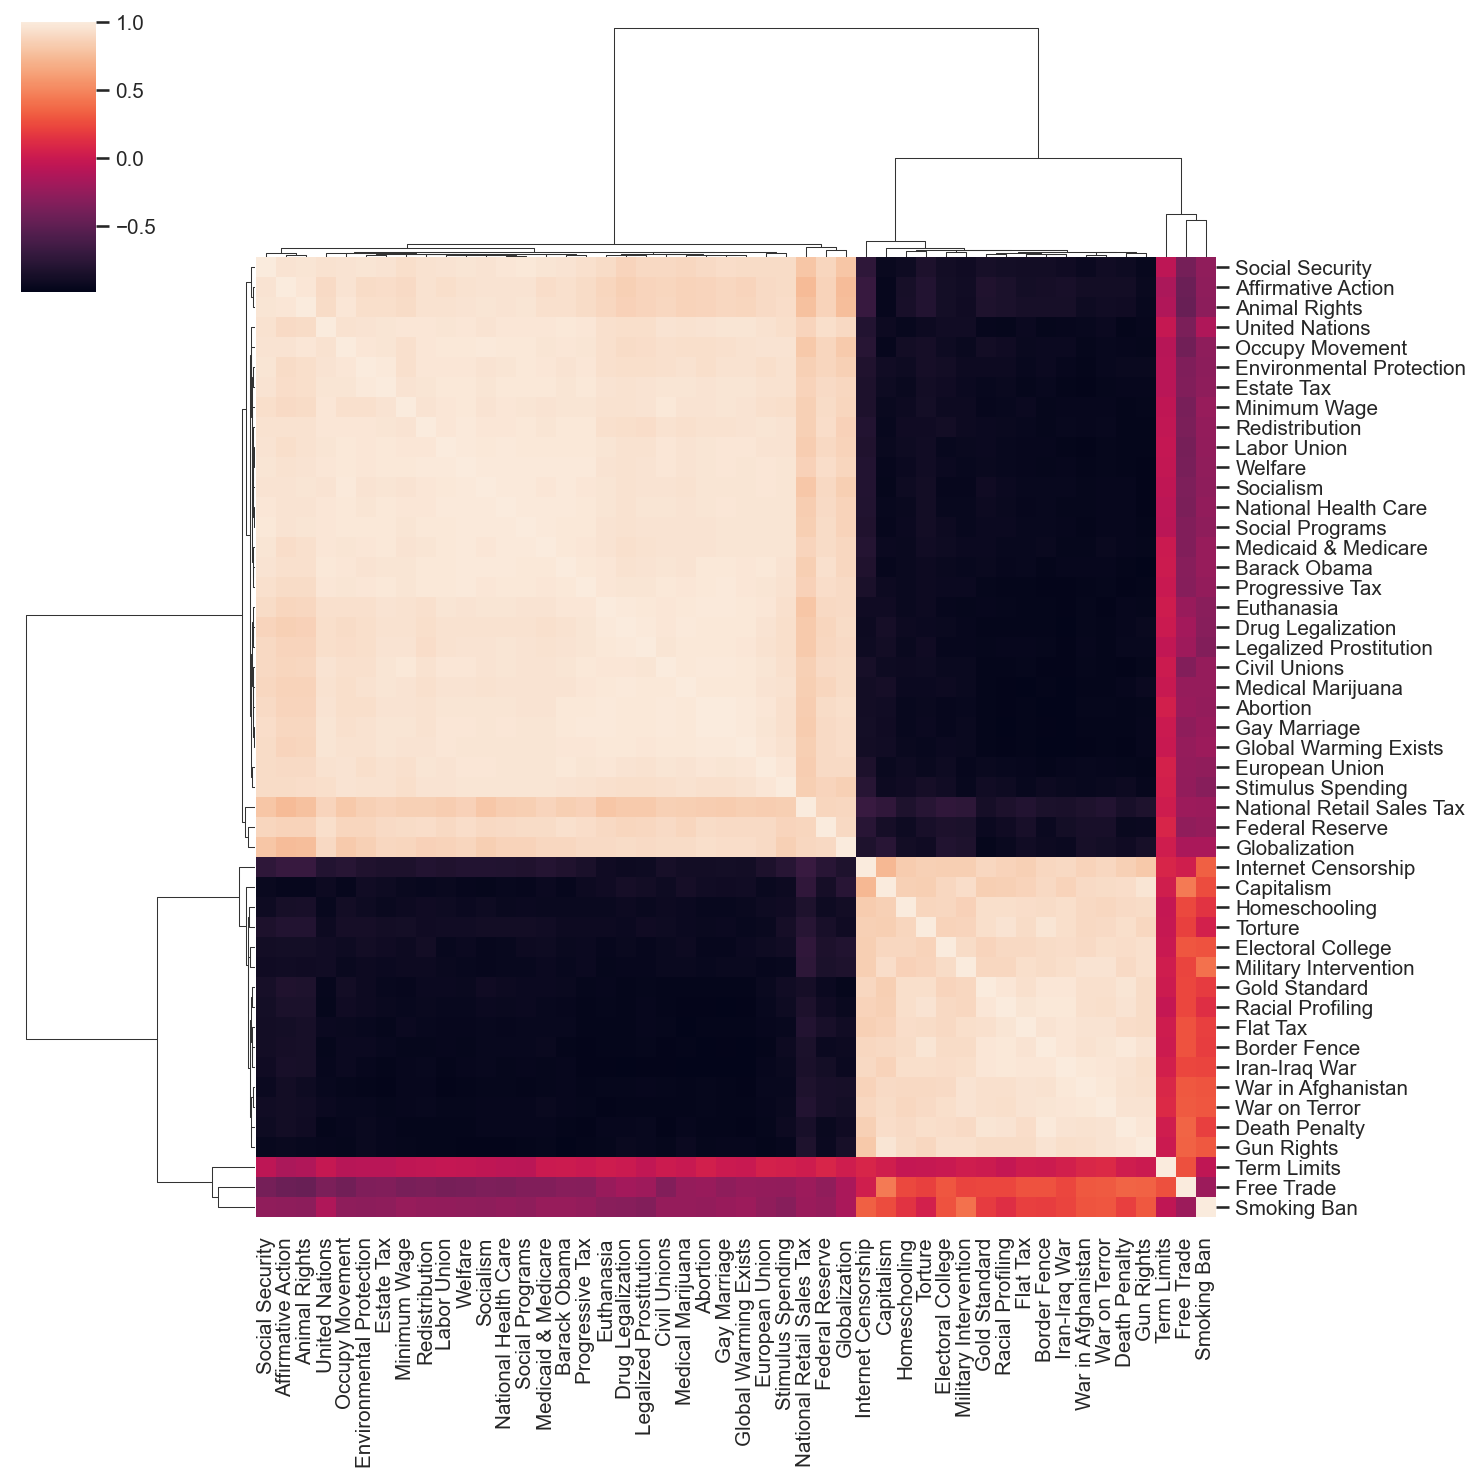

In [96]:
df_ = pd.DataFrame(cosine_mat, columns=issue_labels, index=issue_labels)
sns.set(font_scale=0.9)
g = sns.clustermap(df_, yticklabels=True, xticklabels=True)
#plt.savefig('../fig/issue_vector_clustermap.png', dpi=200, transparent=True, bbox_inches='tight')